In [1]:
# import necessary libraries:

import torch, torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder, VisionDataset

from PIL import Image

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

import os.path as osp 
import cv2
import os

from tqdm import tqdm

from sklearn.metrics import classification_report, accuracy_score

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Helping Functions

In [3]:
def plot_subplots(
    images: np.ndarray,
) -> None:

    max_cols = 8

    fig, axes = plt.subplots(1, max_cols, figsize=(18, 2))

    num_cols = images.shape[0]

    img = images

    for col in range(num_cols):
        if col >= max_cols: break
        axes[col].imshow(img[1 + col])
    plt.show()

## Vizualise Some Images

In [4]:
images_path = np.random.choice(os.listdir("/kaggle/input/truss-dataset/data/images/"), 9)

In [5]:
images = np.stack([cv2.imread(osp.join("/kaggle/input/truss-dataset/data/images/", image_path)) for image_path in images_path])

In [6]:
images.shape

(9, 300, 300, 3)

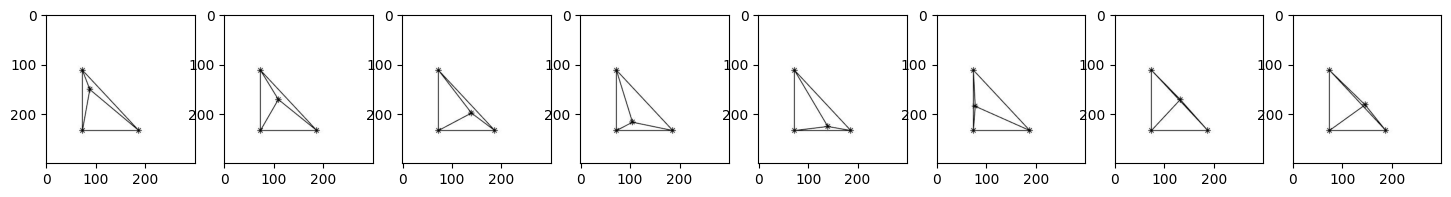

In [7]:
plot_subplots(images)

### Load images For PyTroch

In [8]:
class TrussDataset(VisionDataset):

    def __init__(self, root_dir: str = "./data", transform = None) -> None:
        super(TrussDataset, self).__init__(root=root_dir)

        self.root_dir = root_dir

        self.transform = transform
            
        self.sorted_paths = sorted(os.listdir(osp.join(self.root_dir, "images")),
                                   key = lambda path: int(path.split("ICTSD")[1].split(".")[0])
                            )

        self.target = torch.load(osp.join(self.root_dir, "energy.pt")).type(torch.float32) * 100.


    def __len__(self):
        return len(self.target)
    
    def __getitem__(self, idx):
        img_name = osp.join(self.root_dir, "images", self.sorted_paths[idx])
        image = Image.open(img_name).convert('RGB')
        target = self.target[idx]
    
        if self.transform:
            image = self.transform(image)
    
        return image, target


In [9]:
transform = transforms.Compose([
    transforms.ToTensor(),     
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
])

In [10]:
dataset = TrussDataset(root_dir='/kaggle/input/truss-dataset/data/', transform=transform)

In [61]:
2001*0.2/25

16.008000000000003

In [54]:
2001*0.8/100

16.008000000000003

In [11]:
dataset

Dataset TrussDataset
    Number of datapoints: 2001
    Root location: /kaggle/input/truss-dataset/data/

In [12]:
dataset[300][1]

tensor(2.0429)

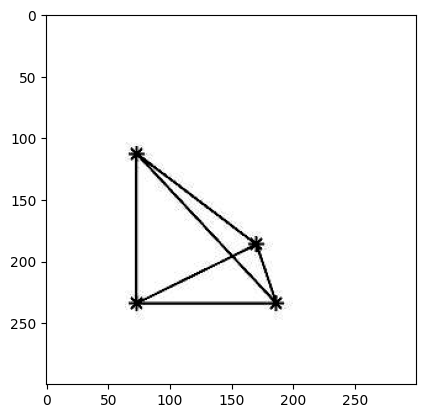

In [13]:
plt.imshow(dataset[300][0].permute(1, 2, 0).numpy())

In [62]:
train_set, test_set = random_split(dataset, [0.8, 0.2])

In [63]:
train_loader = DataLoader(train_set, batch_size= 100, shuffle=True)

In [64]:
test_loader = DataLoader(test_set, batch_size= 25, shuffle=True)

### Build TinyVGG Model

In [76]:
class TinyVGG(nn.Module):

    def __init__(self, filters=10):
        super(TinyVGG, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=filters, kernel_size=3, padding=1), 
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(in_channels=filters, out_channels=filters, kernel_size=3, padding=1), 
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=filters, out_channels=filters, kernel_size=3, padding=1), 
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(in_channels=filters, out_channels=filters, kernel_size=3, padding=1), 
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.flatten = nn.Flatten()
        
        self.fc = nn.Sequential(
            nn.Linear(filters * 75 * 75, 128),
            nn.LeakyReLU(inplace=True),
            nn.Linear(128, 64),
            nn.LeakyReLU(inplace=True),
            nn.Linear(64, 32),
            nn.LeakyReLU(inplace=True),
            nn.Linear(32, 1)
        )

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        out = self.cnn(input)
        out = self.flatten(out)
        return self.fc(out)

In [77]:
del model
model = TinyVGG().to(device)

In [78]:
model

TinyVGG(
  (cnn): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01, inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): LeakyReLU(negative_slope=0.01, inplace=True)
    (7): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): LeakyReLU(negative_slope=0.01, inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Sequential(
    (0): Linear(in_features=56250, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): LeakyReLU(negative_slope=0.01

In [79]:
inputs, target = next(iter(train_loader))

In [80]:
out = model(inputs.to(device))

In [81]:
criterion = nn.MSELoss()

In [82]:
opt = optim.Adam(model.parameters(), lr=0.01)

In [83]:
# This function is define to train the model, with MSELoss, and Adam optimizer.

def train(
    model,
    criterion,
    optimizer,
    train_loader,
    test_loader,
    epochs=1,
    loggings: bool = True, 
    loggings_iter: int = 400,
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu"),
) -> dict:
    
    model.train()
    
    result = {"train_loss": [], "test_loss": []}
    
    for epoch in range(epochs):
        
        for i, (img, lbl) in tqdm(enumerate(train_loader)):
            
            train_loss = 0
            
            model.train()
        
            optimizer.zero_grad()
        
            pred_lbl = model(img.to(device))
            
            loss = criterion(pred_lbl, lbl.unsqueeze(0).t().to(device))
            
            train_loss = loss.item()
            
            loss.backward()
            
            optimizer.step()
            
            result["train_loss"].append(train_loss)

        # if i%int(loggings_iter)==0:
            
        for i, (test_img, test_target) in enumerate(test_loader):
            model.eval()
            
            test_loss = 0

            test_target_pred = model(test_img.to(device))

            test_loss_ob = criterion(test_target_pred, test_target.unsqueeze(0).t().to(device))

            test_loss = test_loss_ob.item()

            
            result["test_loss"].append(test_loss)

        print(f"Epochs: {epoch:4d} | Iteration: {i:4d}| Train Loss: {train_loss:4.10f}| Test Loss: {test_loss:4.10f}")
        print("-"*140)

    print("-"*140)
    print("Traning is finished :) ")
    
    return result

In [84]:
res = train(
    model=model,
    criterion=criterion,
    optimizer=opt,
    train_loader=train_loader,
    test_loader=test_loader,
    epochs=10
)

17it [00:05,  3.34it/s]


Epochs:    0 | Iteration:   15| Train Loss: 1.0561798811| Test Loss: 5.2851705551
--------------------------------------------------------------------------------------------------------------------------------------------


17it [00:05,  3.36it/s]


Epochs:    1 | Iteration:   15| Train Loss: 0.0337253138| Test Loss: 0.8100780845
--------------------------------------------------------------------------------------------------------------------------------------------


17it [00:05,  3.29it/s]


Epochs:    2 | Iteration:   15| Train Loss: 1.5683574677| Test Loss: 1.6055933237
--------------------------------------------------------------------------------------------------------------------------------------------


17it [00:04,  3.46it/s]


Epochs:    3 | Iteration:   15| Train Loss: 1.8683190346| Test Loss: 0.9887859821
--------------------------------------------------------------------------------------------------------------------------------------------


17it [00:04,  3.45it/s]


Epochs:    4 | Iteration:   15| Train Loss: 2.5620005131| Test Loss: 0.6509086490
--------------------------------------------------------------------------------------------------------------------------------------------


17it [00:04,  3.50it/s]


Epochs:    5 | Iteration:   15| Train Loss: 1.4849395752| Test Loss: 1.2852178812
--------------------------------------------------------------------------------------------------------------------------------------------


17it [00:04,  3.51it/s]


Epochs:    6 | Iteration:   15| Train Loss: 0.8442562819| Test Loss: 1.0426535606
--------------------------------------------------------------------------------------------------------------------------------------------


17it [00:05,  3.32it/s]


Epochs:    7 | Iteration:   15| Train Loss: 0.0761642978| Test Loss: 0.3090013564
--------------------------------------------------------------------------------------------------------------------------------------------


17it [00:04,  3.44it/s]


Epochs:    8 | Iteration:   15| Train Loss: 0.0032837377| Test Loss: 0.0856783688
--------------------------------------------------------------------------------------------------------------------------------------------


17it [00:05,  3.30it/s]


Epochs:    9 | Iteration:   15| Train Loss: 0.0021234208| Test Loss: 0.0373699069
--------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------------------
Traning is finished :) 


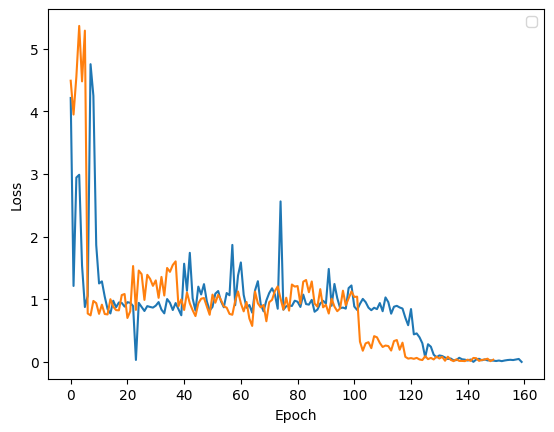

In [90]:
plt.plot(res["train_loss"][10:])
plt.plot(res["test_loss"][10:])

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Saving the figure
plt.savefig('loss_plot.png')

In [92]:
torch.save(model.state_dict(), "./Truss_Strcuture_TinyGVV_v.01.pt")